In [1]:
from __future__ import print_function
from pixell import enmap,utils, reproject, enplot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os,sys
import urllib.request
from scipy import interpolate
from astropy.table import QTable
import astropy.units as u
from astropy.io import fits
import csv
import yaml
from scipy.stats import norm
import matplotlib.patheffects as path_effects
import pickle as pk
from matplotlib.ticker import Locator
%matplotlib inline

In [60]:
forced_phot_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/MADCOWSUnion_M500.fits')
mdcw_catalog = fits.open('/home/s/sievers/sdicker/ACTnCOWs/MADCOWSUnion.fits')


names = forced_phot_catalog[1].data['name']
yc = forced_phot_catalog[1].data['y_c']
yc_err =forced_phot_catalog[1].data['err_y_c']

mdcw_names = mdcw_catalog[1].data['name']
mdcw_rich = mdcw_catalog[1].data['rich']
mdcw_rich_err = mdcw_catalog[1].data['e_rich']

rich = []
rich_err = []

for i in range(len(names)):
    idx = np.where((names[i] == mdcw_names))[0]
    rich.append(int(mdcw_rich[idx]))
    rich_err.append(int(mdcw_rich_err[idx]))


flag = np.where((np.array(rich) != 999999) & (np.array(rich) != 0))[0]
yc, yc_err, rich, rich_err = np.array(yc)[flag], np.array(yc_err)[flag], np.array(rich)[flag], np.array(rich_err)[flag]
flag = np.where((np.abs(yc_err)<1))[0]
yc, yc_err, rich, rich_err = np.array(yc)[flag], np.array(yc_err)[flag], np.array(rich)[flag], np.array(rich_err)[flag]


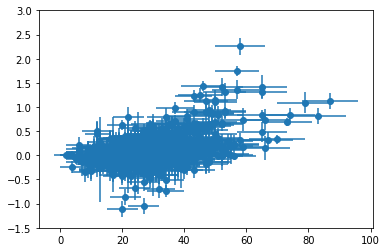

In [64]:
plt.errorbar(rich, yc, xerr=rich_err, yerr = yc_err, fmt = 'o', linestyle = 'none')
#plt.scatter(rich, yc_err)
plt.ylim(-1.5,3)
plt.show()

In [54]:
print(max(yc))


2.2531723079520027
